In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

sys.path.append('/Applications/OpenFUSIONToolkit/python')
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, gs_Domain, read_eqdsk

from omfit_classes.omfit_eqdsk import boundaryShape

In [2]:
def resize_polygon(points, dx):
    new_points = np.empty(np.shape(points))
    for i in range(np.shape(points)[0]):
        if i==0:
            last = points[-1,:]
            next = points[i+1,:]
        elif i == np.shape(points)[0]-1:
            last = points[i-1,:]
            next = points[0,:]
        else:
            next = points[i+1,:]
            last = points[i-1,:]
        par = points[i,:]-last
        par/= np.linalg.norm(par)
        perp = np.array([par[1], -par[0]])
        temp = points[i,:] + perp*dx
        par_2 = next-points[i,:]
        par_2/= np.linalg.norm(par_2)
        perp_2 = [par_2[1], -par_2[0]]
        new_points[i, :] = temp + dx/np.dot(perp_2,par)*par  + par*dx/np.dot(par_2,perp)*np.dot(par_2,par)
    return new_points

In [3]:
def corners(r,z,dr,dz):
    rs = np.array([r+dr/2, r+dr/2, r-dr/2, r-dr/2, r+dr/2])
    zs = np.array([z+dz/2, z-dz/2, z-dz/2, z+dz/2, z+dz/2])
    return np.column_stack((rs,zs))

In [4]:
def closest(plasma, lim):
    min = 1E10
    point = [0,0]
    for i in range(np.size(lim[:,0])):
        distances = np.sqrt((plasma[:,0]-lim[i,0])**2 +(plasma[:,1]-lim[i,1])**2 )
        if np.min(distances)<min:
            min = np.min(distances)
            point = plasma[np.argmin(distances),:]
    return point, min*100

In [5]:
r,z,zeff= boundaryShape(kapu = 1.55, kapl = 1.55, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.413, eps = 0.413/0.85, zoffset = 0, upnull = False, lonull = False, npts = 8)
lim1 = np.column_stack((r,z))
vv1 = resize_polygon(lim1, 0.03)

lim2 = resize_polygon(lim1, -0.05)
vv2 = resize_polygon(lim2, 0.02)

lim3 = resize_polygon(lim1, -0.1)
vv3 = resize_polygon(lim3, 0.03)

In [6]:
coils = {
    'CS0': {'rc': 0.375, 'zc': -.54, 'w': 0.05, 'h': 0.35},
    'CS1': {'rc': 0.375, 'zc': 0, 'w': 0.05, 'h': 0.7},
    'CS2': {'rc': 0.375, 'zc': .54, 'w': 0.05, 'h': 0.35},

    'EF0U': {'rc': .588, 'zc': 0.53, 'w': 0.1, 'h': 0.1},
    'EF1U': {'rc': 1.115, 'zc': 0.745, 'w': 0.1, 'h': 0.1},
    'EF2U': {'rc': 1.245, 'zc': 0.645, 'w': 0.1, 'h': 0.1},
    'EF3U': {'rc': 1.7, 'zc': 0.4, 'w': .15, 'h': .15},

    'EF0L': {'rc': .588, 'zc': -0.53, 'w': 0.1, 'h': 0.1},
    'EF1L': {'rc': 1.115, 'zc': -0.745, 'w': 0.1, 'h': 0.1},
    'EF2L': {'rc': 1.245, 'zc': -0.645, 'w': 0.1, 'h': 0.1},
    'EF3L': {'rc': 1.7, 'zc': -0.4, 'w': .15, 'h': .15},
  
}

In [7]:
## Define mesh resolution in each region
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.03
vac_resolution = 0.075

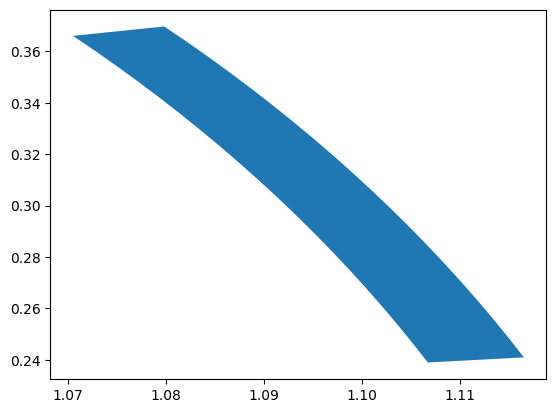

In [8]:
r,z,zeff= boundaryShape(kapu = 1.75, kapl = 1.75, delu = -0.4, dell = -0.4, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.28, eps = 0.28/0.85, zoffset = 0, upnull = False, lonull = False)
#plt.plot(r,z)
pp_inner = np.column_stack((r,z))
pp_outer = resize_polygon(pp_inner, 0.01)
#plt.plot(pp_outer[:,0], pp_outer[:,1])
start = 30
stop = 50
#plt.plot(pp_inner[start:stop, 0],pp_inner[start:stop, 1])
#plt.plot(pp_outer[start:stop, 0],pp_outer[start:stop, 1])

plate = np.concatenate((pp_inner[start:stop,:], np.flip(pp_outer[start:stop,:], 0)))
plt.fill(plate[:,0], plate[:,1])
plate_lower = np.copy(plate)
plate_lower[:,1] = -plate[:,1]

In [13]:
# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1.33e-6)
gs_mesh.define_region('plate_upper',vv_resolution,'conductor',eta=3.8E-8)
gs_mesh.define_region('plate_lower',vv_resolution,'conductor',eta=3.8E-8)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

In [14]:
# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

gs_mesh.add_polygon(plate, 'plate_upper')
gs_mesh.add_polygon(plate_lower, 'plate_lower')

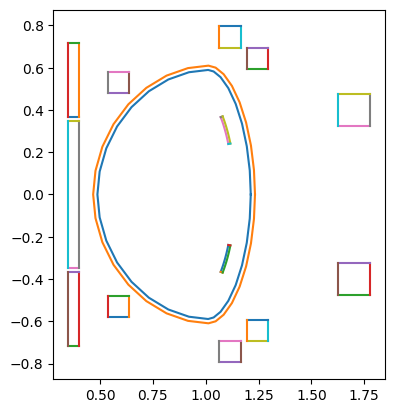

In [15]:
## Plot geometry
fig, ax = plt.subplots(1,1)
for region in gs_mesh.regions:
    region.plot_segments(fig,ax)
ax.set_aspect('equal','box')

In [16]:
#Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

Assembling regions:
  # of unique points    = 526
  # of unique segments  = 58
Generating mesh:
  # of points  = 3782
  # of cells   = 7456
  # of regions = 16


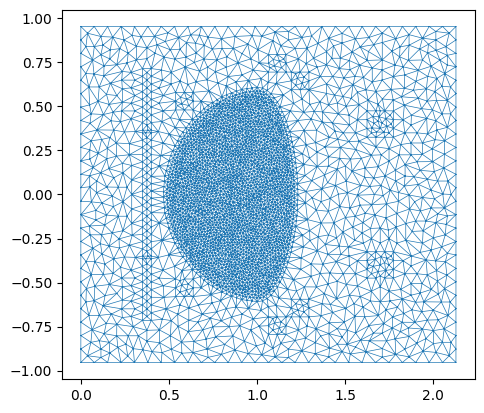

In [13]:
# Plot mesh
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
ax.triplot(mesh_pts[:,0],mesh_pts[:,1], lw = 0.5)

In [14]:
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.85*3) ## F0 = R0 * B0

#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    3780
    # of edges   =   11231
    # of cells   =    7452
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  1.241E-02
    hrms =  3.766E-02
    hmax =  1.138

In [15]:
coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1

mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)


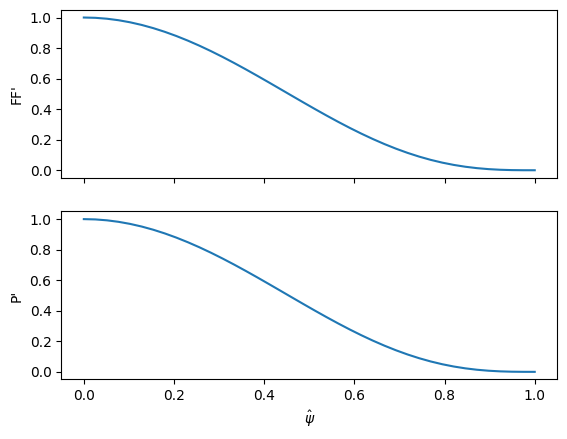

In [16]:
# Define shape of P' anf FF' profiles

n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)

# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

In [17]:
#Define global quantities
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1) #Can change poloidal beta by modifying Ip_ratio target

In [18]:
##Set shape targets
kappa = 1.9
delta = -0.5

r, z, zeff = boundaryShape(kapu = kappa, kapl = kappa, delu = delta, dell = delta, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
isoflux_weights = 10*np.ones(32)
mygs.set_isoflux(boundary, isoflux_weights)

#Set saddle targets
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]

x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)



In [19]:
mygs.init_psi(0.8,0,0.22, kappa,delta) #Initial "guess"
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  8.8725E+00  5.7821E+00  5.2013E-02  8.8662E-01  1.0625E-05 -0.0000E+00
     2  9.5625E+00  6.2657E+00  1.8228E-02  8.8745E-01  1.7988E-06 -0.0000E+00
     3  9.8544E+00  6.4737E+00  6.1054E-03  8.8759E-01 -2.8218E-06 -0.0000E+00
     4  1.0016E+01  6.5893E+00  2.3913E-03  8.8754E-01 -5.7454E-06 -0.0000E+00
     5  1.0109E+01  6.6560E+00  1.0903E-03  8.8745E-01 -7.7708E-06 -0.0000E+00
     6  1.0162E+01  6.6945E+00  5.5058E-04  8.8737E-01 -9.2999E-06 -0.0000E+00
     7  1.0193E+01  6.7168E+00  2.9430E-04  8.8731E-01 -1.0498E-05 -0.0000E+00
     8  1.0211E+01  6.7297E+00  1.6212E-04  8.8727E-01 -1.1406E-05 -0.0000E+00
     9  1.0221E+01  6.7371E+00  9.0761E-05  8.8724E-01 -1.2086E-05 -0.0000E+00
    10  1.0227E+01  6.7413E+00  5.1278E-05  8.8722E-01 -1.2613E-05 -0.0000E+00
    11  1.0230E+01  6.7438E+00  2.9124E-05  8.8721E-01 -1.3036E-05 -0.0000E+00
    12  1.0232E+01  6.7452E+00  1.6591E-05  8.8720E-01 -1.3380E-05 -0.0000E+00
    13  1.0233E+01  6.

0

[0.98079904 0.48640677]
[ 0.98067923 -0.48651577]
hi
Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.0000E+06
  Current Centroid [m]    =    0.875 -0.000
  Magnetic Axis [m]       =    0.887 -0.000
  Elongation              =    1.841 (U:  1.778, L:  1.904)
  Triangularity           =   -0.418 (U: -0.337, L: -0.500)
  Plasma Volume [m^3]     =    1.929
  q_0, q_95               =    0.613  2.493
  Peak Pressure [Pa]      =    3.8528E+05
  Stored Energy [J]       =    1.9108E+05
  <Beta_pol> [%]          =   52.6145
  <Beta_tor> [%]          =    1.9552
  Diamagnetic flux [Wb]   =    9.7269E-03
  Toroidal flux [Wb]      =    1.0803E+00
  l_i                     =    1.2246


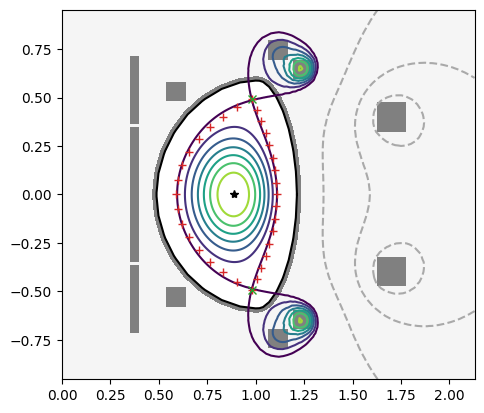

In [20]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax)
mygs.print_info()

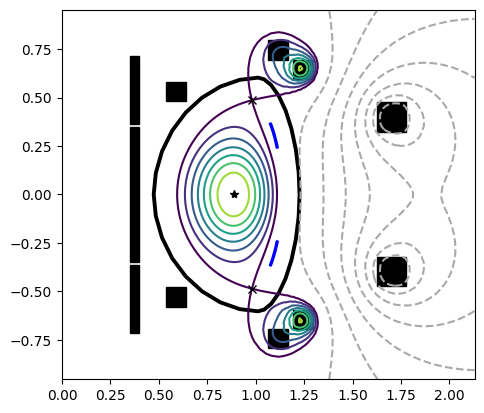

In [21]:
fig, ax = plt.subplots()
plt.gca().set_aspect(aspect = 1)
plt.fill(vv2[:,0], vv2[:,1], color = 'black')
plt.fill(lim2[:,0], lim2[:,1], color = 'white')

for key, coil in coils.items():
    plt.fill(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k')

plt.fill(plate[:,0], plate[:,1],color = 'blue')
plt.fill(plate_lower[:,0], plate_lower[:,1], color = 'blue')

mygs.plot_psi(fig,ax)

0.0040467799350369016
-4.673878762329911


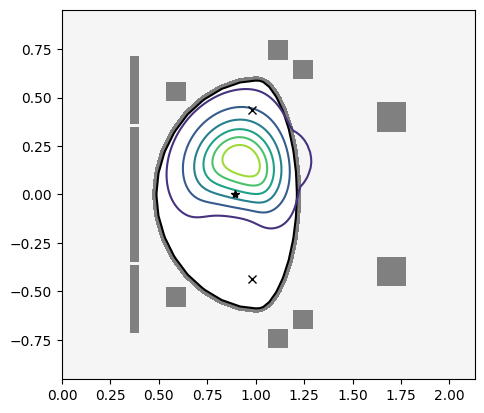

In [20]:
eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
eig_wall, eigvec_wall = mygs.eig_wall()
fig, ax = plt.subplots()
mygs.plot_machine(fig,ax)
mygs.plot_psi(fig,ax,psi = eig_vecs[0,:], normalized = False)
print(1/eig_wall[1,0])
print(eig_vals[0,0]/eig_wall[1,0])


#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    3782
    # of edges   =   11237
    # of cells   =    7456
    # of boundary points =     106
    # of boundary edges  =     106
    # of boundary cells  =     106
  Resolution statistics:
    hmin =  9.998E-03
    hrms =  3.760E-02
    hmax =  1.097

Saving EQDSK file
 "none"
Flux surfaces from 600x600 gEQDSK
Levels based on psi ...
Grid diagonal resolution: 0.0025365011216131003 [m]
Cropping tables ...
Find magnetic axis ...
Find separatrix ...
Tracing flux surfaces ...
  > Took 0:00:01.713650
Find Br, Bz, F on flux surfaces ...
  > Took 0:00:00.991061
Flux surface averaging ...
  > Took 0:00:01.251089
Geometric quantities ...
  > Took 0:00:02.988719
[ 0.92694684 -0.38729095]
[0.92698058 0.3872944 ]
bye
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend    

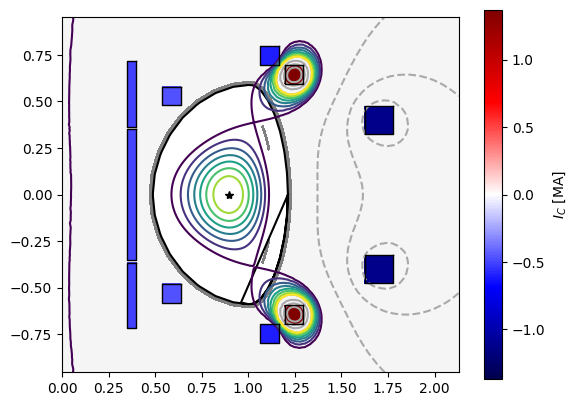

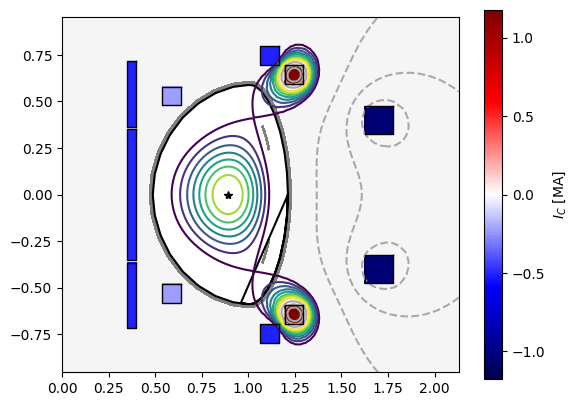

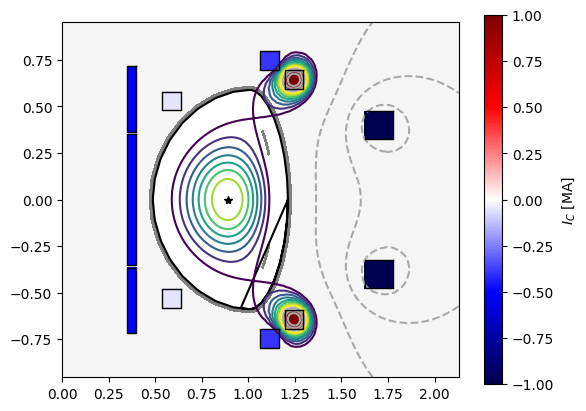

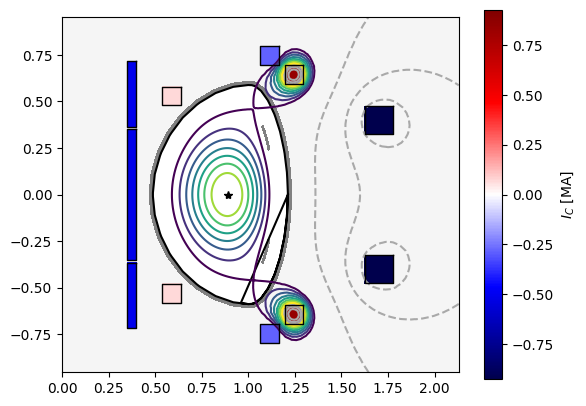

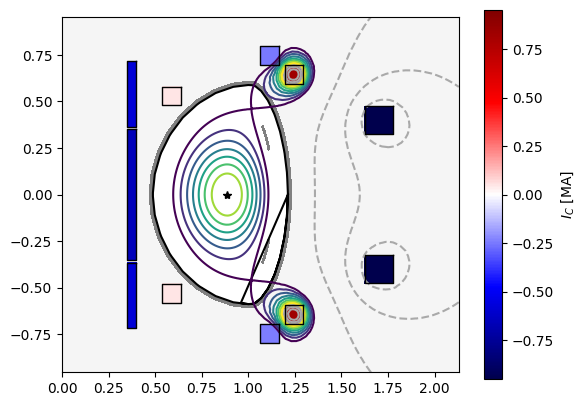

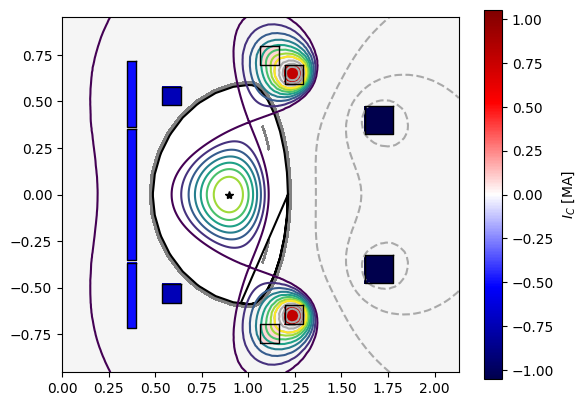

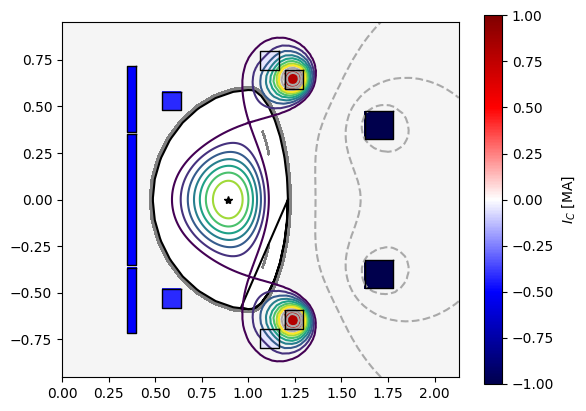

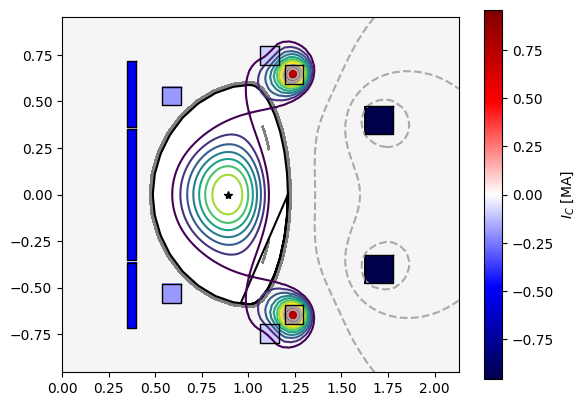

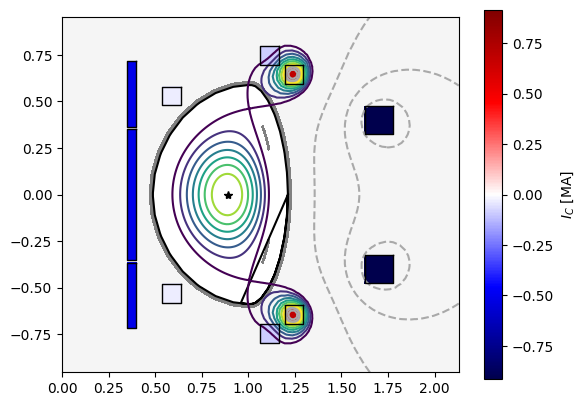

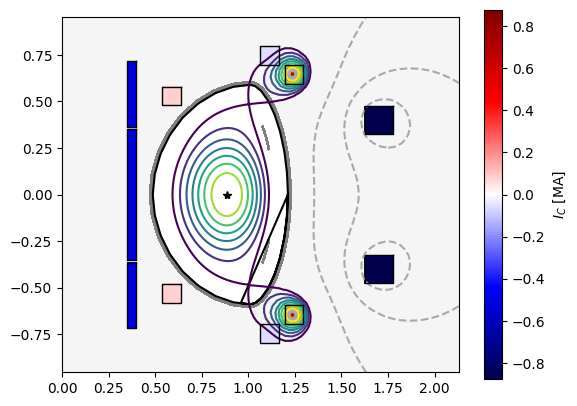

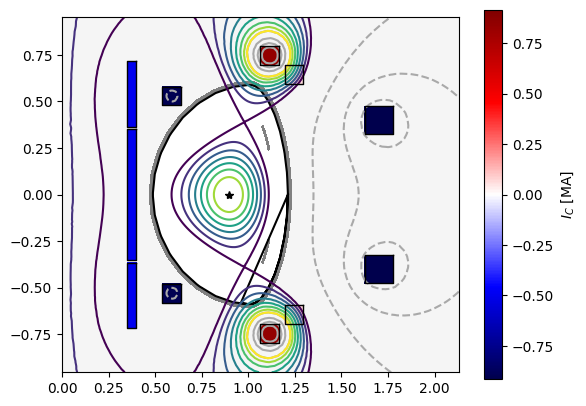

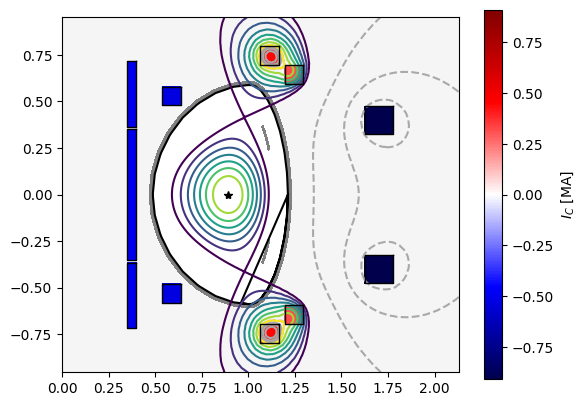

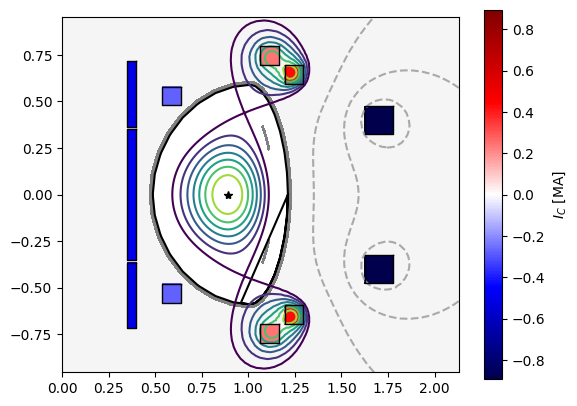

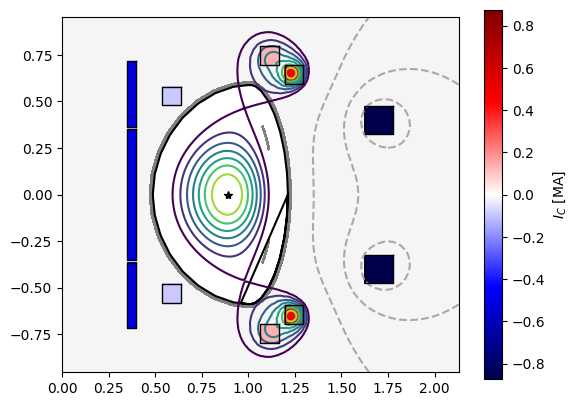

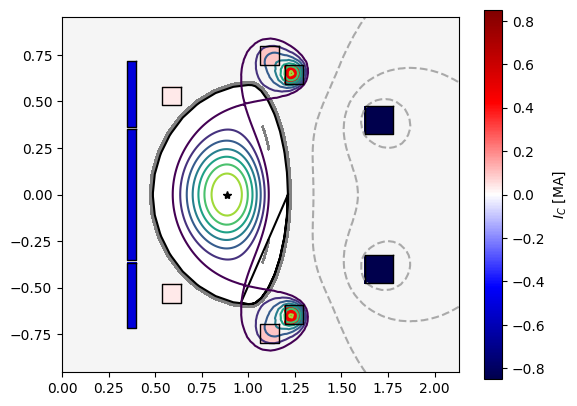

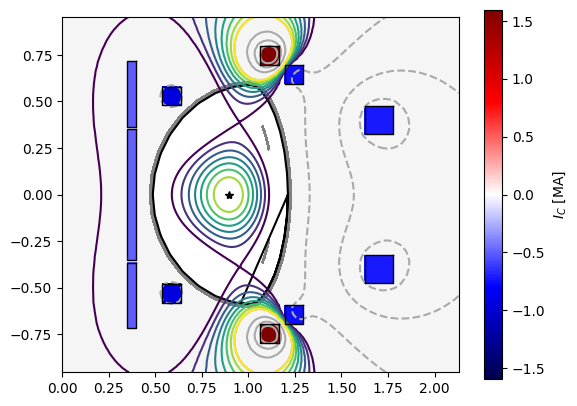

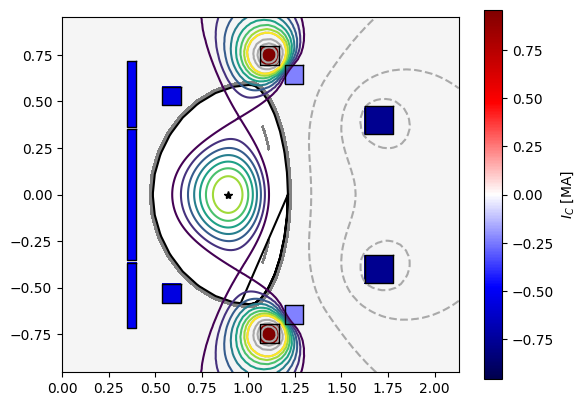

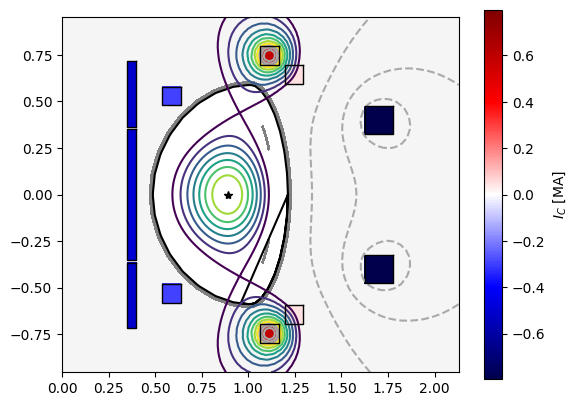

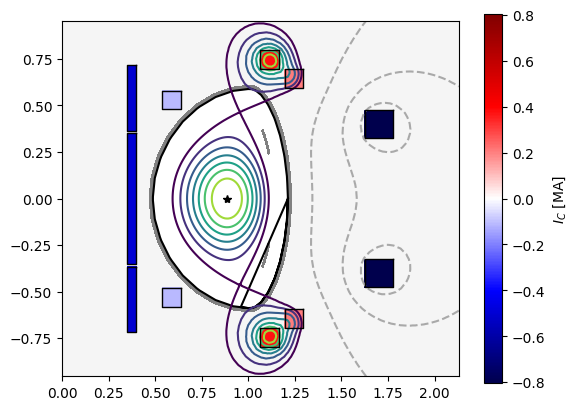

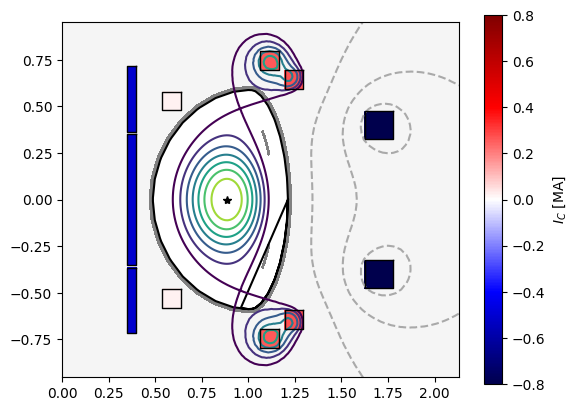

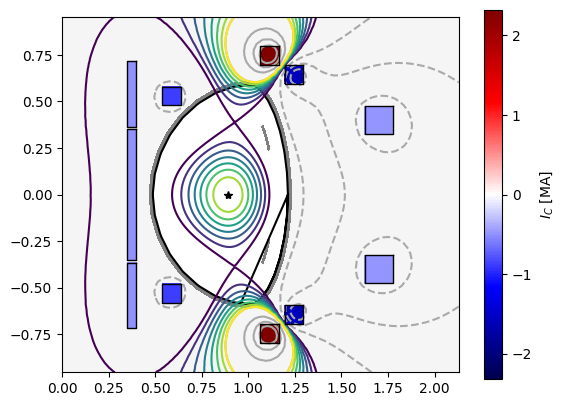

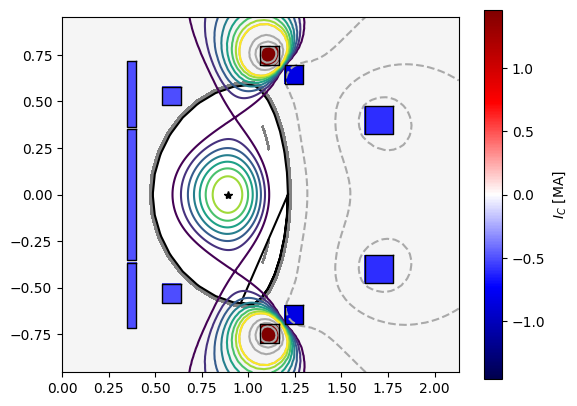

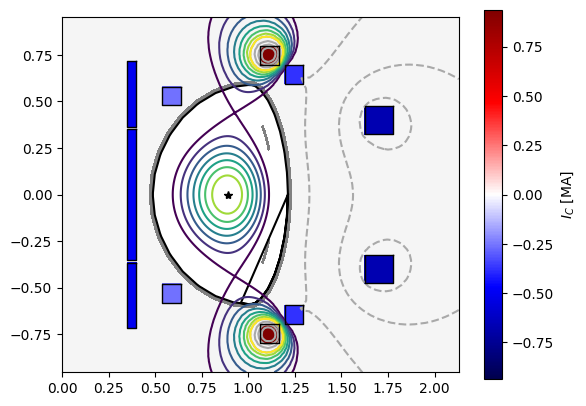

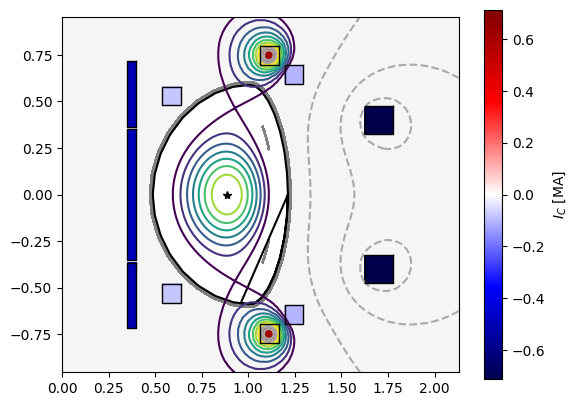

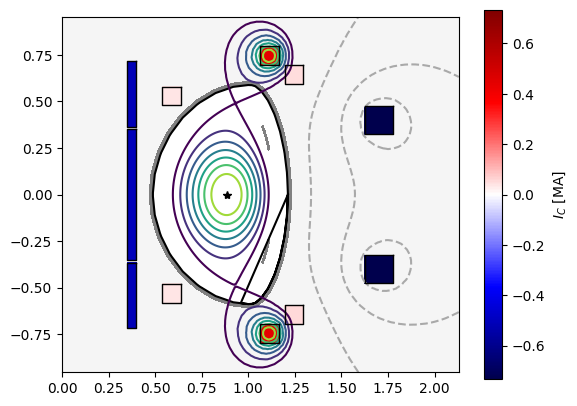

In [17]:
import copy
from omfit_classes.omfit_eqdsk import OMFITgeqdsk
d_omfit = []
e_omfit = []
d_tok = []
e_tok = []
q95 = []
betap = []
li = []
coil_currents = []
ds = np.linspace(-0.7, -.3, 5)
es = np.linspace(1.5, 1.9, 5)
dist = []
gammas = []
taus = []
eqdsks = []
lcfs = []

for d in ds: 
    for e in es:
        mygs = TokaMaker()
        mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
        mygs.setup_regions(cond_dict=cond_dict)
        mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

        coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
        targets = np.zeros(mygs.ncoils+1)
        coil_weights = 0.5*np.ones(mygs.ncoils+1)

        #Set target values for CS coils
        coil_reg_mat[0,0] = 1
        coil_reg_mat[1,1] = 1
        coil_reg_mat[2,2] = 1
        targets[0] = -5E5
        targets[1] = -5E5 
        targets[2] = -5E5

        #Enforce up/down symmetry in PF coils
        coil_reg_mat[3,3] = 1
        coil_reg_mat[3,7] = -1
        coil_reg_mat[4,4] = 1
        coil_reg_mat[4,8] = -1
        coil_reg_mat[5,5] = 1
        coil_reg_mat[5,9] = -1
        coil_reg_mat[6,6] = 1
        coil_reg_mat[6,10] = -1
        mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

        #Set upper bound on coil currents
        coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
        coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
        mygs.set_coil_bounds(coil_bounds)

        # Define shape of P' anf FF' profiles
        n_sample = 40
        psi_sample = np.linspace(0.0,1.0,n_sample)
        # Set F*F' profile
        alpha = 2
        gamma = 3
        ffp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
        # Set P' profile
        alpha = 2
        gamma = 3
        pp_prof = {
            'type': 'linterp',
            'x': psi_sample,
            'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
        }
        pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

        mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

        # set global targets
        Ip_target = 1E6
        mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

        # set boundary/saddle point targets
        r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
        boundary = np.column_stack((r,z))
        x_points = np.zeros((2,2))
        x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
        x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
        x_weights = 5*np.ones(2)
        mygs.set_saddles(x_points, x_weights)
        isoflux_weights = 10*np.ones(32)

        if d < -0.65 and e > 1.85:
            isoflux_weights = 30*np.ones(32)
            print('catch')
        
        mygs.set_isoflux(boundary, isoflux_weights)

        #find equilibrium
        mygs.init_psi(0.68,0,0.2, 1.8,0.3)
        mygs.settings.maxits = 100
        mygs.update_settings()
        mygs.solve()

        #plot equilibrium
        fig, ax = plt.subplots(1,1)
        mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
        mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
        for key, coil in coils.items():
            plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

        #save as eqdsk
        mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)

        eqdsk = OMFITgeqdsk('temp')
        d_omfit.append(eqdsk['fluxSurfaces']['geo']['delta'][-1])    
        e_omfit.append(eqdsk['fluxSurfaces']['geo']['kap'][-1])
        
        point, distance = closest(read_eqdsk('temp')['rzout'], lim2)
        dist.append(distance)

        lcfs.append(read_eqdsk('temp')['rzout'])
        stats = mygs.get_stats()
        q95.append(stats['q_95'])
        betap.append(stats['beta_pol'])
        li.append(stats['l_i'])
        d_tok.append(stats['delta'])
        e_tok.append(stats['kappa'])

        eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
        gammas.append(eig_vals[0,0])

        eig_wall, eigvec_wall = mygs.eig_wall()
        taus.append(1/eig_wall[1][0])

        #extract coil currents
        current,currentmap = mygs.get_coil_currents()
        coil_currents.append(current)
        

        mygs.reset()

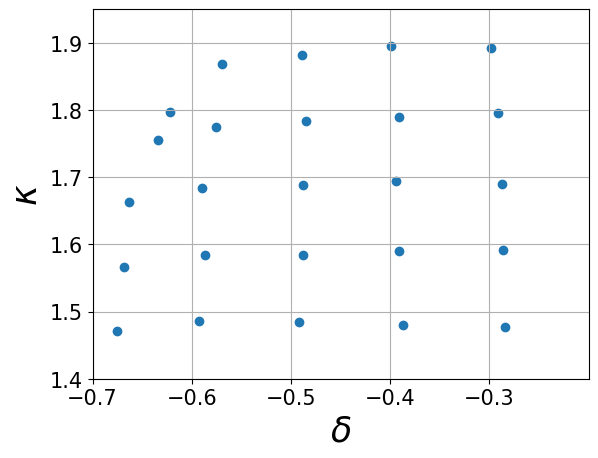

In [18]:
#OMFIT geometry calcs
plt.scatter(d_omfit, e_omfit)
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()

In [16]:
print(dist)

[10.088700154165876, 10.075344173477834, 10.009699937196622, 9.969434069521208, 10.48391288469199, 10.185376297556365, 10.268366090498091, 10.234257918820182, 10.209608865775403, 9.961960409833729, 10.148540301126026, 10.289708929465267, 10.285039859253795, 10.294264861537865, 10.30302095702687, 10.129031007868509, 10.18204393557716, 10.242292904447124, 10.290487908233095, 10.331654884368398, 9.969539953227526, 10.071001875952485, 10.169511868251622, 10.260817859382861, 10.012761480366912]


In [19]:
gamma = np.array(gammas)
tau = np.array(taus)

In [18]:
print(gamma*tau*-1)
print(gamma)
print(tau)

[ 2.598127    3.9637412   6.24293728  9.81189854 19.70408187  2.3652451
  3.51899324  5.46764557  8.9006774  15.20084991  2.02690523  3.0235195
  4.67377669  7.39844992 13.04657926  1.69381156  2.68987372  4.12500089
  6.3264229  10.41380293  1.3999676   2.29967721  3.63214463  5.66480632
  8.93722065]
[ -642.02329888  -979.48029456 -1542.69255478 -2424.61875806
 -4869.07669393  -584.47583923  -869.57860301 -1351.1101801
 -2199.44685399 -3756.2828099   -500.86865555  -747.14206086
 -1154.93719957 -1828.23134465 -3223.94087921  -418.55786233
  -664.69483503 -1019.32918365 -1563.32269231 -2573.35538392
  -345.94606648  -568.27335439  -897.539447   -1399.83058349
 -2208.47705948]
[0.00404678 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678
 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678
 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678
 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678 0.00404678
 0.00404678]


In [ ]:
##0.00404678

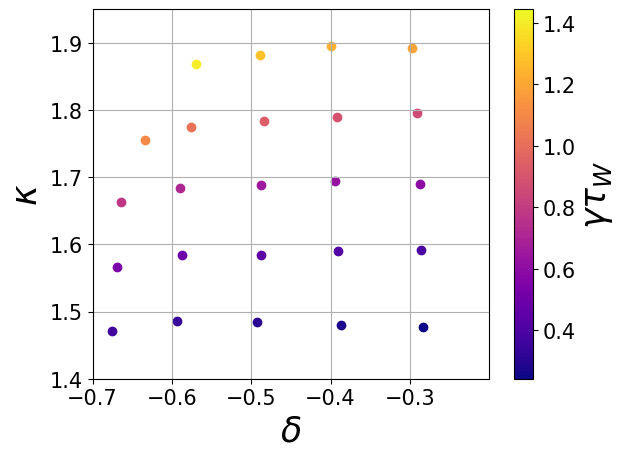

In [21]:
gt = np.array(gamma*0.00404678*-1)
norm = plt.Normalize(np.min(gt), np.max(gt))
cmap = mpl.cm.plasma(np.linspace(0,1,100))
cmap = mpl.colors.ListedColormap(cmap[:,:-1])
c = cmap(norm(gt))

for i in range(25):
    if i is not 4:
        plt.scatter(d_omfit[i], e_omfit[i], color = c[i])
plt.xlabel(r'$\delta$', size = 25)
plt.ylabel(r'$\kappa$', size = 25)
plt.xlim([-0.7, -0.2])
plt.ylim([1.4, 1.95])
plt.xticks(np.linspace(-0.7, -0.3, 5),size = 15)
plt.yticks(size = 15)
plt.grid()
sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$\gamma \tau_{W}$', size = 25)
cb.ax.tick_params(labelsize=15)

NameError: name 'lcfs' is not defined

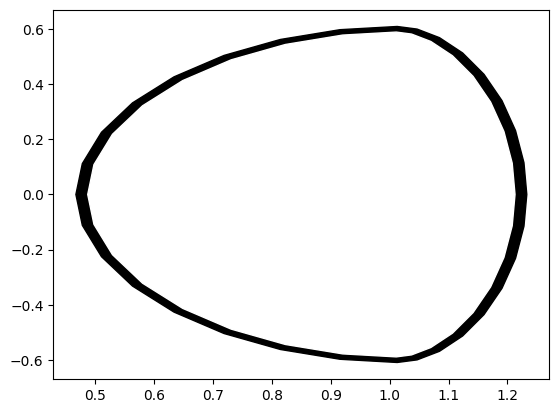

In [9]:
fig, ax = plt.subplots()
plt.fill(vv2[:,0], vv2[:,1], color = 'k')
plt.fill(lim2[:,0], lim2[:,1], color = 'w')
for i in range(25):
    if i is not 4:
        plt.plot(lcfs[i][:,0], lcfs[i][:,1], color = c[i])

plt.gca().set_aspect(aspect = 1)

plt.xlabel(r'R (m)', size = 25)
plt.ylabel(r'Z (m)', size = 25)
plt.xticks(size = 15)
plt.yticks(size = 15)

r,z,zeff= boundaryShape(kapu = 1.8, kapl = 1.8, delu = -0.5, dell = -0.5, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.28, eps = 0.28/0.85, zoffset = 0, upnull = False, lonull = False)
plt.plot(r,z)
pp_inner = np.column_stack((r,z))
pp_outer = resize_polygon(pp_inner, 0.01)
plt.plot(pp_outer[:,0], pp_outer[:,1])
start = 30
stop = 50
#plt.plot(pp_inner[start:stop, 0],pp_inner[start:stop, 1])
#plt.plot(pp_outer[start:stop, 0],pp_outer[start:stop, 1])

plate = np.concatenate((pp_inner[start:stop,:], np.flip(pp_outer[start:stop,:], 0)))
plt.fill(plate[:,0], plate[:,1])




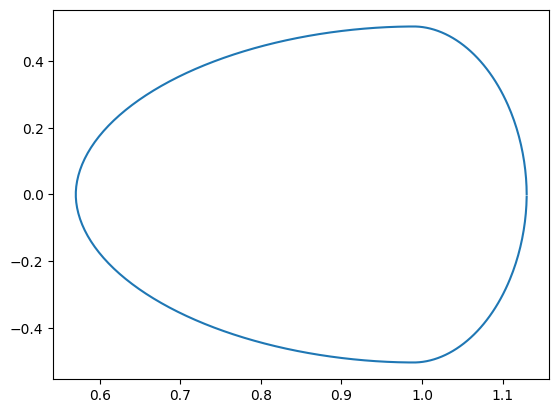

In [9]:
r,z,zeff= boundaryShape(kapu = 1.8, kapl = 1.8, delu = -0.5, dell = -0.5, zetail = -.03, zetaiu = -.03, zetaou = -.03, zetaol = -.03, a = 0.28, eps = 0.28/0.85, zoffset = 0, upnull = False, lonull = False)
plt.plot(r,z)
ps_path = np.column_stack((r,z))

In [12]:
def place_points(npoints, arc):
    arclength = np.zeros(np.size(arc[:,0]))
    for i,point in enumerate(arc):
        if i==0:
            arclength[i] = 0
        else:

            arclength[i] = arclength[i-1] + ((arc[i,0]-arc[i-1,0])**2+(arc[i,1]-arc[i-1,1])**2)**0.5

    spacing = arclength[-1]/npoints
    curr = 1
    inds = [0]
    locs = [arc[0,:]]
    for i, point in enumerate(arc):
        if(arclength[i]>curr*spacing and curr<npoints):
            inds.append(i)
            locs.append(arc[i])
            curr+=1
    return np.array(inds), np.array(locs)

[[ 0.93556173  0.49891903]
 [ 0.83814138  0.46602772]
 [ 0.75388116  0.40989184]
 [ 0.68120439  0.33238845]
 [ 0.62815211  0.245776  ]
 [ 0.59127882  0.14928344]
 [ 0.57238358  0.04856008]
 [ 0.57238358 -0.04856008]
 [ 0.59127882 -0.14928344]
 [ 0.62815211 -0.245776  ]
 [ 0.68120439 -0.33238845]
 [ 0.75388116 -0.40989184]
 [ 0.83814138 -0.46602772]
 [ 0.92855118 -0.49757248]]


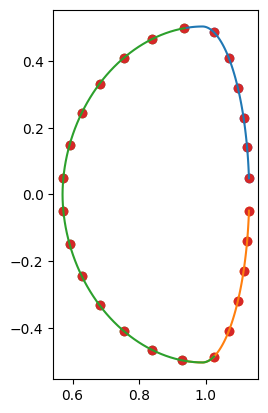

In [11]:

plt.gca().set_aspect(aspect = 1)
ps_ur = ps_path[6:98,:]
ps_lr = np.flip(ps_path[263:355,:],0)
ps_l = ps_path[98:286,:]
inds_ur, locs_ur = place_points(6,ps_ur)
inds_lr, locs_lr = place_points(6,ps_lr)
inds_l, locs_l = place_points(14, ps_l)

plt.plot(ps_ur[:,0], ps_ur[:,1])
plt.plot(ps_lr[:,0], ps_lr[:,1])
plt.plot(ps_l[:,0], ps_l[:,1])


print(locs_l)

plt.scatter(locs_ur[:,0], locs_ur[:,1])
plt.scatter(locs_lr[:,0], locs_lr[:,1])
plt.scatter(locs_l[:,0], locs_l[:,1])

inds = np.concatenate((inds_ur + 6, inds_l+98, np.flip(354-inds_lr,0)))
#locs = np.concatenate((locs_ur,locs_l, locs_lr))

plt.scatter(ps_path[inds,0], ps_path[inds,1])
#print(ps_path[inds,:])
#print(inds)

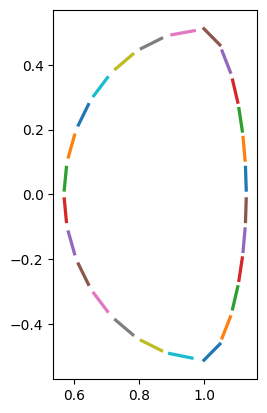

In [12]:
derivs = []
for i, point in enumerate(ps_path):
    if i==0:
        last = ps_path[-1,:]
        next = ps_path[i+1,:]
    elif i == np.size(ps_path[:,0])-1:
        last = ps_path[i-1,:]
        next = ps_path[0,:]
    else: 
        next = ps_path[i+1,:]
        last = ps_path[i-1,:]
    
    derivs.append((next-last)/np.linalg.norm(next-last))

derivs = np.array(derivs)
orth = np.transpose([derivs[:,1], -derivs[:,0]])
length = .08
width = .01
ps_points = []
for i in inds:
    center = ps_path[i,:]
    p1 = center + length/2*derivs[i,:] + width/2*orth[i,:]
    p2 = center + length/2*derivs[i,:] - width/2*orth[i,:]
    p3 = center - length/2*derivs[i,:] - width/2*orth[i,:]
    p4 = center - length/2*derivs[i,:] + width/2*orth[i,:]

    ps_points.append([p1, p2, p3, p4])

ps_points = np.array(ps_points)
for i in range(26):
    plt.fill(ps_points[i,:,0], ps_points[i,:,1])

plt.gca().set_aspect(aspect = 1)

In [7]:
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.075
vac_resolution = 0.075

gammas = []

e = 1.9
d = -0.5

for i in range(13):

    # Create a G-S domain
    gs_mesh = gs_Domain()
    # Define region information for mesh
    gs_mesh.define_region('air',vac_resolution,'boundary')
    gs_mesh.define_region('plasma',plasma_resolution,'plasma')
    gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1.33e-6)
    gs_mesh.define_region('plate_upper',vv_resolution,'conductor',eta=3.8E-8)
    gs_mesh.define_region('plate_lower',vv_resolution,'conductor',eta=3.8E-8)
    # Define each of the coils
    for key, coil in coils.items():
        gs_mesh.define_region(key,coil_resolution,'coil')

    # Define vaccum vessel geometry
    gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
    # Define the shape of the coils
    for key, coil in coils.items():
        gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

    gs_mesh.add_polygon(ps_points[i,:,:], 'plate_upper')
    gs_mesh.add_polygon(ps_points[25-i,:,:], 'plate_lower')

    #Create mesh
    mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
    coil_dict = gs_mesh.get_coils()
    cond_dict = gs_mesh.get_conductors()

    
    mygs = TokaMaker()
    mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
    mygs.setup_regions(cond_dict=cond_dict)
    mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

    coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
    targets = np.zeros(mygs.ncoils+1)
    coil_weights = 0.5*np.ones(mygs.ncoils+1)

    #Set target values for CS coils
    coil_reg_mat[0,0] = 1
    coil_reg_mat[1,1] = 1
    coil_reg_mat[2,2] = 1
    targets[0] = -5E5
    targets[1] = -5E5 
    targets[2] = -5E5

    #Enforce up/down symmetry in PF coils
    coil_reg_mat[3,3] = 1
    coil_reg_mat[3,7] = -1
    coil_reg_mat[4,4] = 1
    coil_reg_mat[4,8] = -1
    coil_reg_mat[5,5] = 1
    coil_reg_mat[5,9] = -1
    coil_reg_mat[6,6] = 1
    coil_reg_mat[6,10] = -1
    mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
    coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
    coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
    mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
    n_sample = 40
    psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
    alpha = 2
    gamma = 3
    ffp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
    # Set P' profile
    alpha = 2
    gamma = 3
    pp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

    mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

    # set global targets
    Ip_target = 1E6
    mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

    # set boundary/saddle point targets
    r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
    boundary = np.column_stack((r,z))
    x_points = np.zeros((2,2))
    x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
    x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
    x_weights = 5*np.ones(2)
    mygs.set_saddles(x_points, x_weights)
    isoflux_weights = 10*np.ones(32)
        
    mygs.set_isoflux(boundary, isoflux_weights)

    #find equilibrium
    mygs.init_psi(0.68,0,0.2, 1.8,0.3)
    mygs.settings.maxits = 100
    mygs.update_settings()
    mygs.solve()

    #plot equilibrium
    fig, ax = plt.subplots(1,1)
    mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
    for key, coil in coils.items():
        plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

    #save as eqdsk
    eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
    gammas.append(eig_vals[0,0])

    mygs.reset()


NameError: name 'ps_points' is not defined

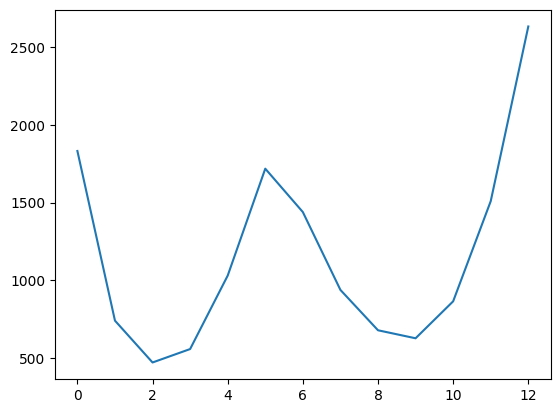

In [12]:
plt.plot(-np.array(gammas))

In [15]:
mygs.reset()
d = -0.5
e = 1.9

Assembling regions:
  # of unique points    = 506
  # of unique segments  = 50
Generating mesh:
  # of points  = 3780
  # of cells   = 7452
  # of regions = 14
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    3780
    # of edges   =   11231
    # of cells   =    7452
    # of boundary points =     

NameError: name 'gammas' is not defined

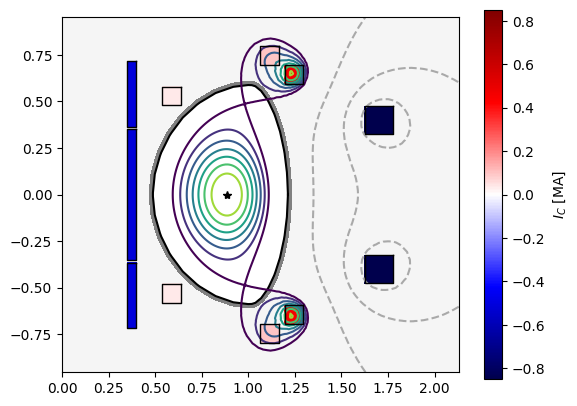

In [8]:
d = -0.5
e = 1.9

gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_resolution,'boundary')
gs_mesh.define_region('plasma',plasma_resolution,'plasma')
gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1.33e-6)
#gs_mesh.define_region('plate_upper',vv_resolution,'conductor',eta=3.8E-8)
#gs_mesh.define_region('plate_lower',vv_resolution,'conductor',eta=3.8E-8)
# Define each of the coils
for key, coil in coils.items():
    gs_mesh.define_region(key,coil_resolution,'coil')

# Define vaccum vessel geometry
gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
# Define the shape of the coils
for key, coil in coils.items():
    gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

#gs_mesh.add_polygon(ps_points[i,:,:], 'plate_upper')
#gs_mesh.add_polygon(ps_points[25-i,:,:], 'plate_lower')

    #Create mesh
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

    
mygs = TokaMaker()
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
targets = np.zeros(mygs.ncoils+1)
coil_weights = 0.5*np.ones(mygs.ncoils+1)

#Set target values for CS coils
coil_reg_mat[0,0] = 1
coil_reg_mat[1,1] = 1
coil_reg_mat[2,2] = 1
targets[0] = -5E5
targets[1] = -5E5 
targets[2] = -5E5

#Enforce up/down symmetry in PF coils
coil_reg_mat[3,3] = 1
coil_reg_mat[3,7] = -1
coil_reg_mat[4,4] = 1
coil_reg_mat[4,8] = -1
coil_reg_mat[5,5] = 1
coil_reg_mat[5,9] = -1
coil_reg_mat[6,6] = 1
coil_reg_mat[6,10] = -1
mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

#Set upper bound on coil currents
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
mygs.set_coil_bounds(coil_bounds)

# Define shape of P' anf FF' profiles
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)
# Set F*F' profile
alpha = 2
gamma = 3
ffp_prof = {
    'type': 'linterp',
    'x': psi_sample,
    'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
# Set P' profile
alpha = 2
gamma = 3
pp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
}
pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

# set global targets
Ip_target = 1E6
mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

# set boundary/saddle point targets
r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
boundary = np.column_stack((r,z))
x_points = np.zeros((2,2))
x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
x_weights = 5*np.ones(2)
mygs.set_saddles(x_points, x_weights)
isoflux_weights = 10*np.ones(32)
        
mygs.set_isoflux(boundary, isoflux_weights)

#find equilibrium
mygs.init_psi(0.68,0,0.2, 1.8,0.3)
mygs.settings.maxits = 100
mygs.update_settings()
mygs.solve()

#plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
for key, coil in coils.items():
    plt.plot(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

#save as eqdsk
eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
gammas.append(eig_vals[0,0])



Saving EQDSK file
 "none"


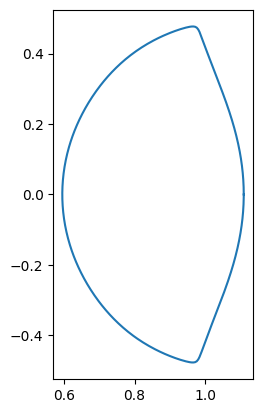

In [9]:
mygs.save_eqdsk('temp', lcfs_pad = .001, nr = 600, nz = 600)
boundary = read_eqdsk('temp')['rzout']
plt.plot(boundary[:,0], boundary[:,1])
plt.gca().set_aspect(aspect =1 )

In [10]:
boundary = resize_polygon(boundary, 0.05)

[[ 0.92128515  0.51877595]
 [ 0.82084815  0.47605044]
 [ 0.73462544  0.41560595]
 [ 0.663334    0.33978771]
 [ 0.6054003   0.2484332 ]
 [ 0.56670112  0.15141075]
 [ 0.54711401  0.04908459]
 [ 0.54814867 -0.05927422]
 [ 0.56982941 -0.16174388]
 [ 0.61088549 -0.25897347]
 [ 0.66886596 -0.34687977]
 [ 0.74230584 -0.42223477]
 [ 0.8305135  -0.48136082]
 [ 0.93374987 -0.52228574]]


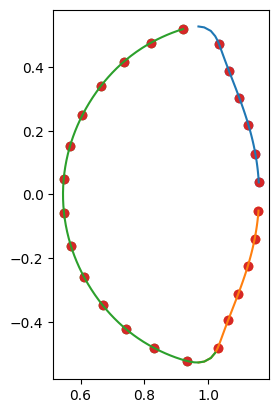

In [31]:

plt.gca().set_aspect(aspect = 1)
ps_ur = boundary[15:135,:]
ps_lr = np.flip(boundary[465:580,:],0)
ps_l = boundary[140:469,:]
inds_ur, locs_ur = place_points(6,ps_ur)
inds_lr, locs_lr = place_points(6,ps_lr)
inds_l, locs_l = place_points(14, ps_l)

plt.plot(ps_ur[:,0], ps_ur[:,1])
plt.plot(ps_lr[:,0], ps_lr[:,1])
plt.plot(ps_l[:,0], ps_l[:,1])


print(locs_l)

plt.scatter(locs_ur[:,0], locs_ur[:,1])
plt.scatter(locs_lr[:,0], locs_lr[:,1])
plt.scatter(locs_l[:,0], locs_l[:,1])

inds = np.concatenate((inds_ur + 15, inds_l+140, np.flip(579-inds_lr,0)))
#locs = np.concatenate((locs_ur,locs_l, locs_lr))

plt.scatter(boundary[inds,0], boundary[inds,1])
#print(ps_path[inds,:])
#print(inds)

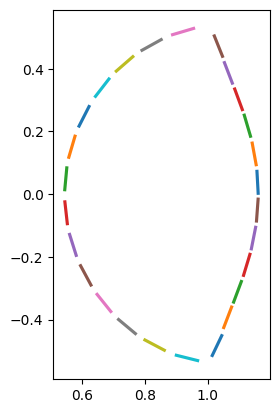

In [32]:
derivs = []
for i, point in enumerate(boundary):
    if i==0:
        last = boundary[-1,:]
        next = boundary[i+1,:]
    elif i == np.size(boundary[:,0])-1:
        last = boundary[i-1,:]
        next = boundary[0,:]
    else: 
        next = boundary[i+1,:]
        last = boundary[i-1,:]
    
    derivs.append((next-last)/np.linalg.norm(next-last))

derivs = np.array(derivs)
orth = np.transpose([derivs[:,1], -derivs[:,0]])
length = .08
width = .01
ps_points = []
for i in inds:
    center = boundary[i,:]
    p1 = center + length/2*derivs[i,:] + width/2*orth[i,:]
    p2 = center + length/2*derivs[i,:] - width/2*orth[i,:]
    p3 = center - length/2*derivs[i,:] - width/2*orth[i,:]
    p4 = center - length/2*derivs[i,:] + width/2*orth[i,:]

    ps_points.append([p1, p2, p3, p4])

ps_points = np.array(ps_points)
for i in range(26):
    plt.fill(ps_points[i,:,0], ps_points[i,:,1])

plt.gca().set_aspect(aspect = 1)

In [33]:
print(repr(ps_points))

array([[[ 1.16169762,  0.0781089 ],
        [ 1.15171249,  0.07756359],
        [ 1.15607498, -0.00231738],
        [ 1.1660601 , -0.00177207]],

       [[ 1.14583069,  0.16874238],
        [ 1.1359932 ,  0.16694692],
        [ 1.15035687,  0.08824695],
        [ 1.16019436,  0.09004241]],

       [[ 1.11991167,  0.25819775],
        [ 1.11032129,  0.25536499],
        [ 1.13298335,  0.17864191],
        [ 1.14257373,  0.18147467]],

       [[ 1.08896153,  0.34185541],
        [ 1.07958172,  0.33838855],
        [ 1.1073166 ,  0.26335005],
        [ 1.11669642,  0.26681691]],

       [[ 1.05614066,  0.4260105 ],
        [ 1.04680757,  0.42241977],
        [ 1.07553341,  0.34775501],
        [ 1.0848665 ,  0.35134574]],

       [[ 1.02370733,  0.51129057],
        [ 1.01442764,  0.507564  ],
        [ 1.0442402 ,  0.43332647],
        [ 1.05351989,  0.43705304]],

       [[ 0.88151622,  0.51218564],
        [ 0.88436211,  0.50259914],
        [ 0.96105408,  0.52536626],
        [ 0.9582

In [7]:
plates = np.array([[[ 1.11177194,  0.07538242],
        [ 1.10178682,  0.07483712],
        [ 1.1061493 , -0.00504385],
        [ 1.11613442, -0.00449854]],

       [[ 1.09664285,  0.15976503],
        [ 1.08680537,  0.15796951],
        [ 1.10116955,  0.07926963],
        [ 1.11100703,  0.08106515]],

       [[ 1.07304651,  0.2408062 ],
        [ 1.0634467 ,  0.23800554],
        [ 1.08585197,  0.16120708],
        [ 1.09545178,  0.16400773]],

       [[ 1.04529014,  0.31625426],
        [ 1.03589472,  0.31282993],
        [ 1.06328938,  0.23766655],
        [ 1.0726848 ,  0.24109089]],

       [[ 1.01381976,  0.39657511],
        [ 1.00449403,  0.39296529],
        [ 1.03337252,  0.31835945],
        [ 1.04269825,  0.32196926]],

        [[0.9845935 , 0.47677216],
        [0.97520101, 0.47333978],
        [1.00266001, 0.39819989],
        [1.0120525 , 0.40163227]],

       [[0.87101292, 0.45309946],
        [0.87449417, 0.44372498],
        [0.94949002, 0.471575  ],
        [0.94600876, 0.48094948]],

       [[0.78742972, 0.40280808],
        [0.79274617, 0.39433841],
        [0.86050355, 0.43687001],
        [0.8551871 , 0.44533968]],

       [[0.72160643, 0.34206347],
        [0.72846242, 0.33478368],
        [0.78670074, 0.38963164],
        [0.77984475, 0.39691143]],

       [[0.66568876, 0.26689781],
        [0.67378126, 0.26102316],
        [0.72077846, 0.32576312],
        [0.71268597, 0.33163777]],

        [[ 0.62454617,  0.18567507],
        [ 0.63351302,  0.18124837],
        [ 0.66892662,  0.25298314],
        [ 0.65995977,  0.25740984]],

       [[ 0.59794278,  0.09711932],
        [ 0.60755593,  0.09436479],
        [ 0.62959213,  0.17126997],
        [ 0.61997899,  0.17402449]],

       [[ 0.58824117,  0.00511215],
        [ 0.59819871,  0.00419164],
        [ 0.60556283,  0.08385198],
        [ 0.59560529,  0.08477249]],

       [[ 0.5961489 , -0.0878823 ],
        [ 0.60610052, -0.08689985],
        [ 0.59824091, -0.00728687],
        [ 0.58828929, -0.00826932]],

       [[ 0.62113406, -0.17713612],
        [ 0.63072952, -0.17432059],
        [ 0.60820524, -0.09755694],
        [ 0.59860978, -0.10037248]],

        [[ 0.66178173, -0.26054984],
        [ 0.67071982, -0.25606535],
        [ 0.63484387, -0.18456069],
        [ 0.62590579, -0.18904518]],

       [[ 0.71529174, -0.33475319],
        [ 0.72334002, -0.32881812],
        [ 0.67585948, -0.2644318 ],
        [ 0.66781119, -0.27036687]],

       [[ 0.78337743, -0.3997739 ],
        [ 0.79016627, -0.39243145],
        [ 0.73142665, -0.3381207 ],
        [ 0.72463781, -0.34546315]],

       [[ 0.86403355, -0.44984342],
        [ 0.86917069, -0.4412638 ],
        [ 0.80053377, -0.40016668],
        [ 0.79539663, -0.40874629]],

       [[ 0.95118818, -0.48245332],
        [ 0.9545664 , -0.47304122],
        [ 0.8792696 , -0.44601547],
        [ 0.87589138, -0.45542757]],

        [[ 1.01202057, -0.40157049],
        [ 1.002627  , -0.39814108],
        [ 0.97519167, -0.47328961],
        [ 0.98458523, -0.47671903]],

       [[ 1.0404587 , -0.32757288],
        [ 1.03113029, -0.32397001],
        [ 1.00230734, -0.39859733],
        [ 1.01163575, -0.4022002 ]],

       [[ 1.06978276, -0.24947743],
        [ 1.0604037 , -0.24600854],
        [ 1.0326526 , -0.32104105],
        [ 1.04203166, -0.32450993]],

       [[ 1.09376476, -0.17066051],
        [ 1.08418488, -0.16779242],
        [ 1.0612402 , -0.24443146],
        [ 1.07082008, -0.24729955]],

       [[ 1.10990025, -0.0892502 ],
        [ 1.10008297, -0.08734731],
        [ 1.08485987, -0.16588556],
        [ 1.09467715, -0.16778845]],

       [[ 1.11610228, -0.00754194],
        [ 1.1061289 , -0.00681272],
        [ 1.10029516, -0.08659974],
        [ 1.11026854, -0.08732895]]])
        

In [8]:
plates = np.array([[[ 1.16169762,  0.0781089 ],
        [ 1.15171249,  0.07756359],
        [ 1.15607498, -0.00231738],
        [ 1.1660601 , -0.00177207]],

       [[ 1.14583069,  0.16874238],
        [ 1.1359932 ,  0.16694692],
        [ 1.15035687,  0.08824695],
        [ 1.16019436,  0.09004241]],

       [[ 1.11991167,  0.25819775],
        [ 1.11032129,  0.25536499],
        [ 1.13298335,  0.17864191],
        [ 1.14257373,  0.18147467]],

       [[ 1.08896153,  0.34185541],
        [ 1.07958172,  0.33838855],
        [ 1.1073166 ,  0.26335005],
        [ 1.11669642,  0.26681691]],

       [[ 1.05614066,  0.4260105 ],
        [ 1.04680757,  0.42241977],
        [ 1.07553341,  0.34775501],
        [ 1.0848665 ,  0.35134574]],

       [[ 1.02370733,  0.51129057],
        [ 1.01442764,  0.507564  ],
        [ 1.0442402 ,  0.43332647],
        [ 1.05351989,  0.43705304]],

       [[ 0.88151622,  0.51218564],
        [ 0.88436211,  0.50259914],
        [ 0.96105408,  0.52536626],
        [ 0.95820819,  0.53495276]],

       [[ 0.78344813,  0.46100919],
        [ 0.78830137,  0.45226584],
        [ 0.85824816,  0.49109169],
        [ 0.85339493,  0.49983504]],

       [[ 0.7011776 ,  0.39310614],
        [ 0.70774518,  0.38556512],
        [ 0.76807328,  0.43810577],
        [ 0.7615057 ,  0.44564679]],

       [[ 0.63489269,  0.31122039],
        [ 0.64279977,  0.30509844],
        [ 0.69177531,  0.36835504],
        [ 0.68386823,  0.37447698]],

       [[ 0.58276583,  0.21507633],
        [ 0.5916732 ,  0.21053113],
        [ 0.62803476,  0.28179007],
        [ 0.6191274 ,  0.28633526]],

       [[ 0.55062814,  0.1144424 ],
        [ 0.5602226 ,  0.11162346],
        [ 0.5827741 ,  0.18837911],
        [ 0.57317964,  0.19119805]],

       [[ 0.53845326,  0.00971466],
        [ 0.54841081,  0.00879417],
        [ 0.55577476,  0.08845452],
        [ 0.54581721,  0.08937502]],

       [[ 0.54761121, -0.09958193],
        [ 0.55754964, -0.09847399],
        [ 0.54868613, -0.01896652],
        [ 0.5387477 , -0.02007446]],

       [[ 0.57707461, -0.20139873],
        [ 0.58661287, -0.19839515],
        [ 0.56258422, -0.12208903],
        [ 0.55304596, -0.12509261]],

       [[ 0.62539264, -0.29658388],
        [ 0.63420421, -0.29185565],
        [ 0.59637834, -0.22136306],
        [ 0.58756677, -0.2260913 ]],

       [[ 0.68995725, -0.38123319],
        [ 0.69776452, -0.37498446],
        [ 0.64777467, -0.31252635],
        [ 0.6399674 , -0.31877508]],

       [[ 0.76978221, -0.45173137],
        [ 0.77619749, -0.44406037],
        [ 0.71482948, -0.39273817],
        [ 0.7084142 , -0.40040918]],

       [[ 0.86353716, -0.50447874],
        [ 0.86821161, -0.49563852],
        [ 0.79748985, -0.4582429 ],
        [ 0.7928154 , -0.46708312]],

       [[ 0.97134566, -0.53683073],
        [ 0.97376917, -0.52712884],
        [ 0.89615408, -0.50774075],
        [ 0.89373057, -0.51744264]],

       [[ 1.05126036, -0.44898914],
        [ 1.04223925, -0.4446741 ],
        [ 1.00771893, -0.51684299],
        [ 1.01674004, -0.52115803]],

       [[ 1.08253046, -0.35717613],
        [ 1.07319292, -0.35359697],
        [ 1.04455967, -0.42829729],
        [ 1.05389721, -0.43187644]],

       [[ 1.11357145, -0.27565881],
        [ 1.10420741, -0.27214957],
        [ 1.07613348, -0.34706188],
        [ 1.08549752, -0.35057112]],

       [[ 1.14074593, -0.18853705],
        [ 1.13117623, -0.18563517],
        [ 1.1079612 , -0.26219275],
        [ 1.11753089, -0.26509463]],

       [[ 1.15855711, -0.10168547],
        [ 1.1487465 , -0.09974848],
        [ 1.1332506 , -0.17823337],
        [ 1.14306122, -0.18017036]],

       [[ 1.16596934, -0.01118804],
        [ 1.15599596, -0.0104588 ],
        [ 1.15016205, -0.0902458 ],
        [ 1.16013543, -0.09097504]]])

In [9]:
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.075
vac_resolution = 0.075

gammas = []

e = 1.9
d = -0.5

for i in range(13):

    # Create a G-S domain
    gs_mesh = gs_Domain()
    # Define region information for mesh
    gs_mesh.define_region('air',vac_resolution,'boundary')
    gs_mesh.define_region('plasma',plasma_resolution,'plasma')
    gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1.33e-6)
    gs_mesh.define_region('plate_upper',vv_resolution,'conductor',eta=3.8E-8)
    gs_mesh.define_region('plate_lower',vv_resolution,'conductor',eta=3.8E-8)
    # Define each of the coils
    for key, coil in coils.items():
        gs_mesh.define_region(key,coil_resolution,'coil')

    # Define vaccum vessel geometry
    gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
    # Define the shape of the coils
    for key, coil in coils.items():
        gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

    gs_mesh.add_polygon(plates[i,:,:], 'plate_upper')
    gs_mesh.add_polygon(plates[25-i,:,:], 'plate_lower')

    #Create mesh
    mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
    coil_dict = gs_mesh.get_coils()
    cond_dict = gs_mesh.get_conductors()

    
    mygs = TokaMaker()
    mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
    mygs.setup_regions(cond_dict=cond_dict)
    mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

    coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
    targets = np.zeros(mygs.ncoils+1)
    coil_weights = 0.5*np.ones(mygs.ncoils+1)

    #Set target values for CS coils
    coil_reg_mat[0,0] = 1
    coil_reg_mat[1,1] = 1
    coil_reg_mat[2,2] = 1
    targets[0] = -5E5
    targets[1] = -5E5 
    targets[2] = -5E5

    #Enforce up/down symmetry in PF coils
    coil_reg_mat[3,3] = 1
    coil_reg_mat[3,7] = -1
    coil_reg_mat[4,4] = 1
    coil_reg_mat[4,8] = -1
    coil_reg_mat[5,5] = 1
    coil_reg_mat[5,9] = -1
    coil_reg_mat[6,6] = 1
    coil_reg_mat[6,10] = -1
    mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
    coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
    coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
    mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
    n_sample = 40
    psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
    alpha = 2
    gamma = 3
    ffp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
    # Set P' profile
    alpha = 2
    gamma = 3
    pp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

    mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

    # set global targets
    Ip_target = 1E6
    mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

    # set boundary/saddle point targets
    r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
    boundary = np.column_stack((r,z))
    x_points = np.zeros((2,2))
    x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
    x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
    x_weights = 5*np.ones(2)
    mygs.set_saddles(x_points, x_weights)
    isoflux_weights = 10*np.ones(32)
        
    mygs.set_isoflux(boundary, isoflux_weights)

    #find equilibrium
    mygs.init_psi(0.68,0,0.2, 1.8,0.3)
    mygs.settings.maxits = 100
    mygs.update_settings()
    mygs.solve()

    #plot equilibrium
    #fig, ax = plt.subplots(1,1)
    #mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    #mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
    
    #save as eqdsk
    eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
    gammas.append(eig_vals[0,0])

    mygs.reset()


Assembling regions:
  # of unique points    = 451
  # of unique segments  = 58
Generating mesh:
  # of points  = 3762
  # of cells   = 7416
  # of regions = 16
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    3762
    # of edges   =   11177
    # of cells   =    7416
    # of boundary points =     

In [11]:
print(gammas)

[-2510.940164010113, -1182.1212053578201, -606.6986810791859, -503.1514238811069, -734.7446608238388, -1615.2982637961686, -1826.8802627843543, -1220.5159844509326, -930.6392715402035, -930.107286645667, -1230.970308510965, -1988.8154902979004, -2886.2547422120697]


[Text(1, 0.2, '0.20'),
 Text(1, 0.25, '0.25'),
 Text(1, 0.3, '0.30'),
 Text(1, 0.35, '0.35'),
 Text(1, 0.4, '0.40'),
 Text(1, 0.45, '0.45'),
 Text(1, 0.5, '$\\geq$ 0.50')]

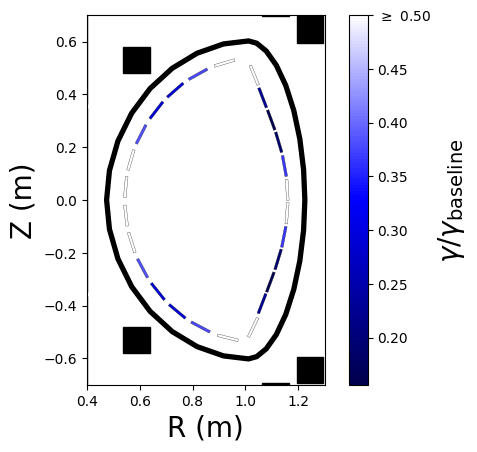

In [15]:
fig, ax = plt.subplots()
plt.fill(vv2[:,0], vv2[:,1], color = 'k')
plt.fill(lim2[:,0], lim2[:,1], color = 'white')

for key, coil in coils.items():
        plt.fill(corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,0],corners(coil['rc'],coil['zc'],coil['w'],coil['h'])[:,1], color = 'k', linewidth = 1)

plt.gca().set_aspect(aspect = 1)

norm = plt.Normalize(np.min(-np.array(gammas))/3223.94087921, np.max(-np.array(gammas))/3223.94087921)
norm = plt.Normalize(np.min(-np.array(gammas))/3223.94087921,0.5)
cmap = mpl.cm.seismic(np.linspace(0,1,1000))
cmap = mpl.colors.ListedColormap(cmap[:500,:-1])
c = cmap(norm(np.array(gammas)/-3223.94087921))

for i in range(13):
    plt.fill(plates[i,:,0], plates[i,:,1], facecolor = c[i], edgecolor = 'k', lw = .2)
    plt.fill(plates[25-i,:,0], plates[25-i,:,1], facecolor = c[i], edgecolor = 'k', lw = .2)

plt.xlim([0.4,1.3])
plt.ylim([-0.7, 0.7])

sm = plt.cm.ScalarMappable(cmap=cmap, norm = norm)
cb = plt.colorbar(sm)
cb.set_label(label=r'$\gamma / \gamma_{\mathrm{baseline}}$', size = 20)

plt.xlabel('R (m)', size = 20)
plt.ylabel('Z (m)', size = 20)
cb.ax.set_yticks([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
cb.ax.set_yticklabels(['0.20', '0.25', '0.30', '0.35', '0.40', '0.45', r'$\geq$ 0.50' ])

In [9]:
plasma_resolution = 0.02
coil_resolution = 0.04
vv_resolution = 0.075
vac_resolution = 0.075

gammas = []

e = 1.9
d = -0.5

for i in range(13):

    # Create a G-S domain
    gs_mesh = gs_Domain()
    # Define region information for mesh
    gs_mesh.define_region('air',vac_resolution,'boundary')
    gs_mesh.define_region('plasma',plasma_resolution,'plasma')
    gs_mesh.define_region('vv',vv_resolution,'conductor',eta=1.33e-6)
    gs_mesh.define_region('plate_upper',vv_resolution,'conductor',eta=3.8E-8)
    gs_mesh.define_region('plate_lower',vv_resolution,'conductor',eta=3.8E-8)
    # Define each of the coils
    for key, coil in coils.items():
        gs_mesh.define_region(key,coil_resolution,'coil')

    # Define vaccum vessel geometry
    gs_mesh.add_annulus(lim2,'plasma',vv2,'vv',parent_name='air')
    # Define the shape of the coils
    for key, coil in coils.items():
        gs_mesh.add_rectangle(coil['rc'],coil['zc'],coil['w'],coil['h'],key,parent_name='air')

    gs_mesh.add_polygon(plate, 'plate_upper')
    gs_mesh.add_polygon(plate_lower, 'plate_lower')

    #Create mesh
    mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
    coil_dict = gs_mesh.get_coils()
    cond_dict = gs_mesh.get_conductors()

    
    mygs = TokaMaker()
    mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
    mygs.setup_regions(cond_dict=cond_dict)
    mygs.setup(order = 2, F0 =0.8*3) ## F0 = B0 * R0

    coil_reg_mat = np.zeros((mygs.ncoils+1,mygs.ncoils+1), dtype=np.float64)
    targets = np.zeros(mygs.ncoils+1)
    coil_weights = 0.5*np.ones(mygs.ncoils+1)

    #Set target values for CS coils
    coil_reg_mat[0,0] = 1
    coil_reg_mat[1,1] = 1
    coil_reg_mat[2,2] = 1
    targets[0] = -5E5
    targets[1] = -5E5 
    targets[2] = -5E5

    #Enforce up/down symmetry in PF coils
    coil_reg_mat[3,3] = 1
    coil_reg_mat[3,7] = -1
    coil_reg_mat[4,4] = 1
    coil_reg_mat[4,8] = -1
    coil_reg_mat[5,5] = 1
    coil_reg_mat[5,9] = -1
    coil_reg_mat[6,6] = 1
    coil_reg_mat[6,10] = -1
    mygs.set_coil_reg(coil_reg_mat, targets, coil_weights)

    #Set upper bound on coil currents
    coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
    coil_bounds[:,0] = -1.E11; coil_bounds[:,1] = 1.E11
    mygs.set_coil_bounds(coil_bounds)

    # Define shape of P' anf FF' profiles
    n_sample = 40
    psi_sample = np.linspace(0.0,1.0,n_sample)
    # Set F*F' profile
    alpha = 2
    gamma = 3
    ffp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    ffp_prof['y'] /= ffp_prof['y'][0] # Normalize profile (not required but convienient)
    # Set P' profile
    alpha = 2
    gamma = 3
    pp_prof = {
        'type': 'linterp',
        'x': psi_sample,
        'y': np.power(1.0-np.power(psi_sample,alpha),gamma)
    }
    pp_prof['y'] /= pp_prof['y'][0] # Normalize profile (not required but convienient)

    mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

    # set global targets
    Ip_target = 1E6
    mygs.set_targets(Ip = Ip_target, Ip_ratio=1.0)

    # set boundary/saddle point targets
    r, z, zeff = boundaryShape(kapu = e, kapl = e, delu = d, dell = d, zetail = 0, zetaiu = 0, zetaou = 0, zetaol = 0, a = 0.2588, eps = 0.2588/0.85, zoffset = 0, upnull = True, lonull = True, npts = 8)
    boundary = np.column_stack((r,z))
    x_points = np.zeros((2,2))
    x_points[0,:] = boundary[np.argmin(boundary[:,1]),:]
    x_points[1,:] = boundary[np.argmax(boundary[:,1]),:]
    x_weights = 5*np.ones(2)
    mygs.set_saddles(x_points, x_weights)
    isoflux_weights = 10*np.ones(32)
        
    mygs.set_isoflux(boundary, isoflux_weights)

    #find equilibrium
    mygs.init_psi(0.68,0,0.2, 1.8,0.3)
    mygs.settings.maxits = 100
    mygs.update_settings()
    mygs.solve()

    #plot equilibrium
    #fig, ax = plt.subplots(1,1)
    #mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
    #mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
        
    
    #save as eqdsk
    eig_vals, eig_vecs = mygs.eig_td(-1.E5,10, include_bounds = True)
    gammas.append(eig_vals[0,0])

    #mygs.reset()


Assembling regions:
  # of unique points    = 451
  # of unique segments  = 58
Generating mesh:
  # of points  = 3778
  # of cells   = 7448
  # of regions = 16
#----------------------------------------------
OpenFUSIONToolkit Initialized
Development branch:   main
Revision id:          11ca7a7
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  4.064E+00
    # of points  =    3778
    # of edges   =   11225
    # of cells   =    7448
    # of boundary points =     

: 